In [1]:
import sys
sys.path.append(r"C:\Users\edwin\Desktop\SQCLab\Python\Script")

import matplotlib.pyplot as plt
import numpy as np
import lmfit
from LogReader import LogHandler
from scipy.signal import argrelextrema

In [2]:
def post_rotate(ydata):
    from scipy.optimize import minimize_scalar
    def rotate_complex(iq, angle):
        return (iq) * np.exp(1j * np.pi * angle/180)

    def std_q(y, rot_agl_):
        iq = rotate_complex(y, rot_agl_)
        return np.std(iq.imag)
    res = minimize_scalar(lambda agl:std_q(ydata, agl), bounds=[0, 360])
    rotation_angle = res.x
    ydata = np.real(rotate_complex(ydata,rotation_angle))
    return ydata

## decay sine

def decaysine_resid(params, xdata, ydata = None, std = None):
    
    amp = params['amp'].value
    freq = params['freq'].value
    phase = params['phase'].value
    decay = params['decay'].value
    offset = params['offset'].value

    y_model = offset + amp * np.sin(2*np.pi*freq*xdata + phase) * np.exp(-xdata/decay)
    if ydata is None:
        return y_model
    return y_model - ydata

def decaysine_guess(xdata, ydata):
    fourier = np.fft.fft(ydata)
    fft_freqs = np.fft.fftfreq(len(ydata), d=xdata[1]-xdata[0])
    fft_phases = np.angle(fourier)
    sorted_fourier = np.sort(fourier)
    max_ind = np.argwhere(fourier == sorted_fourier[-1])[0][0]
    if max_ind == 0:
        max_ind = np.argwhere(fourier == sorted_fourier[-2])[0][0]
    max_freq = np.abs(fft_freqs[max_ind])
    max_phase = fft_phases[max_ind]

    yrange = np.max(ydata) - np.min(ydata)
    xrange = np.max(xdata) - np.min(xdata)
    params = lmfit.create_params(
        amp = dict(value = yrange/2, min = 0.25*yrange, max = 2*yrange),
        freq = dict(value = max_freq, min = 0.1/xrange, max = 15/xrange),
        decay = dict(value = xrange/4, min = 0.0001),
        phase = dict(value = max_phase, min = -np.pi, max = np.pi),
        offset = dict(value = np.mean(ydata), min = np.min(ydata), max = np.max(ydata))
    )
    return params

def expdecay_resid(params, xdata, ydata = None):
    amp = params['amp'].value
    decay = params['decay'].value
    offset = params['offset'].value

    y_model = offset + amp*np.exp(-xdata/decay)
    if ydata is None:
        return y_model
    return y_model - ydata

def expdecay_guess(xdata, ydata):
    xrange = np.max(xdata) - np.min(xdata)
    params = lmfit.create_params(
        amp = dict(value = ydata[0] - ydata[1]),
        decay = dict(value = xrange/4, min = 0),
        offset = dict(value = ydata[-1])
    )
    return params

def amp(Rabi, target):
    return 10*np.log10((target/Rabi)**2)

In [42]:
log = LogHandler(r'C:\Users\SQC\Desktop\ZCU\ZCU_Data\Test045[02]\2024\05\Data_0527\Test045_Rabi_004@-1mA.hdf5')
x,_,y,xname,_,yname = log.output()
# y = post_rotate(y[0])
# y = np.abs(y[0])
y = np.angle(y[0])
x*=1e6

model1 = lmfit.Minimizer(decaysine_resid,decaysine_guess(x,y), fcn_args = (x,), fcn_kws={'ydata': y})
# model1 = lmfit.Minimizer(expdecay_resid,expdecay_guess(x,y), fcn_args = (x,), fcn_kws={'ydata': y})
o1 = model1.minimize(method = 'leastsq')
lmfit.report_fit(o1)
r_squared = 1- (o1.residual.var()/np.var(y))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 75
    # data points      = 51
    # variables        = 5
    chi-square         = 9.2546e-04
    reduced chi-square = 2.0119e-05
    Akaike info crit   = -546.769045
    Bayesian info crit = -537.109917
[[Variables]]
    amp:     0.03192921 +/- 0.00226958 (7.11%) (init = 0.03515846)
    freq:    8.16741033 +/- 0.07540880 (0.92%) (init = 9.803922)
    decay:   1.40737516 +/- 1.18644682 (84.30%) (init = 0.05)
    phase:   2.34335737 +/- 0.05770270 (2.46%) (init = -0.3096166)
    offset: -2.10754642 +/- 6.7263e-04 (0.03%) (init = -2.112446)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decay)    = -0.8909
    C(freq, phase)   = -0.8643
    C(freq, offset)  = -0.2639
    C(phase, offset) = +0.2137
    C(amp, offset)   = +0.1379


0.046 

0.10719999999999999 



Text(0.95, 0.95, '$\\Omega$ = 8.17+/-0.08 MHz\n    $R^2$ = 0.954')

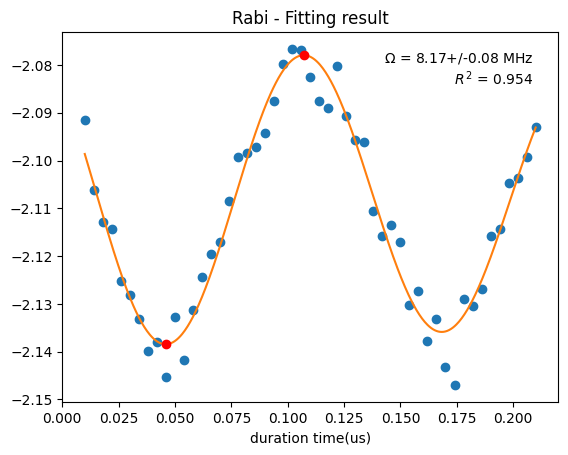

In [43]:
fig, ax = plt.subplots()
fit_x = np.linspace(x[0],x[-1],501)
plt.ticklabel_format(style = 'sci', scilimits = (-3, 3))
ax.set_title('Rabi - Fitting result')
ax.set_xlabel('duration time(us)')
trace = decaysine_resid(o1.params, fit_x)
ax.plot(x,y,'o',fit_x, trace)
points = np.sort([*argrelextrema(trace, np.greater)[0], *argrelextrema(trace, np.less)[0]])[:2]
for point in points:
    ax.plot(fit_x[point],trace[point],'ro')
    print(fit_x[point],'\n')
textstr = \
    f"$\Omega$ = {o1.uvars['freq']:.2f} MHz\n\
    $R^2$ = {r_squared:.3f}"
ax.text(0.95, 0.95, textstr, transform = ax.transAxes, va = 'top', ha = 'right')

In [5]:
amp(1.14, 10)

18.86190297327055